In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import plotting_module as plotting_module

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import OneHotEncoder


## Upload dataset

In [2]:
df = pd.read_csv('df_status.csv').set_index('patient')
df

,status
patient,
0,b
0,b
0,a
0,a
0,a
...,...
118,a
118,a
118,a


## Get all episodes.
Two episodes are considered distinct if they are separated by two or more instances of a. For example, in aabbabbaacbac, there are two episodes: bbabb and cbac.

In [3]:
def get_episodes(string, multiplicities=False):
    """
    string: a string of episodes.
    returns: list of strings; a list of episodes where two episodes are separated by aa.
    
    Example: abacaaaacaaabc -> [bac, c, bc]
    """
    if not multiplicities:
        result = list(set(string.split('aa')).difference(set(['','a'])))
    else:
        result = [element for element in string.split('aa') if element != '' and element != 'a']
    for idx, element in enumerate(result):
        replace = element
        if element[0] == 'a':
            replace = replace[1:]
        if element[-1] == 'a':
            replace = replace[:-1]
        result[idx] = replace
    return result

#get all episodes
ep = set([])

for _ in df.index.value_counts().index:
    string_of_stati = df.loc[_,:].sum()[0]
    ep = ep.union(set(get_episodes(string_of_stati)))
possible_episodes = list(ep)


We construct the transition matrices for each episode. 

In [4]:
all_stati = ['a','b','c'] 
transitions = [_ + __ for _ in all_stati for __ in all_stati]

def get_transitions_single_patient(string):
    """
    Gets transition matrix for a single patient.
    
    Input: a string of letters (like 'aaabcca')
    Output: a 2d np array that is the transition matrix, not renormalized 
    """
    num=3        
    result = np.zeros((num, num))
    for index, letter in enumerate(string):  
        if index > 0:
            oh_transitions = np.eye(num*num)[transitions.index(string[index-1]+letter)]
            result += np.reshape(oh_transitions, (num,  num))
    return result

def get_prob(transitions, flatten=False, fill_in_divide_by_0=1/3):
    """
    renormalizes the transition matrix 
    
    Input: a 3x3 matrix (the matrix of get_transitions_single_patient)
    Output: the matrix of get_transitions_single_patient where each rows sums to 1
    """
    num=3
    for category in range(num):
        if np.sum(transitions[category]) != 0:
            transitions[category] = transitions[category]/np.sum(transitions[category])
        else:
            transitions[category] = np.repeat(fill_in_divide_by_0, num)#all subsequent umori are equally likely if no data
    if not flatten:
        return transitions
    else:
        return transitions.flatten()
    
transition_m_episodes = []
for _ in possible_episodes:
    transition_m_episodes.append(get_prob(get_transitions_single_patient(_), flatten=True,
                                         fill_in_divide_by_0=0))
    
    
transition_m_episodes = np.array(transition_m_episodes)
    

Check that what we have for now looks correct

In [5]:
print(possible_episodes[0])
print(np.reshape(transition_m_episodes[0],(3,3)))
print(possible_episodes[1])
print(np.reshape(transition_m_episodes[1],(3,3)))
print(possible_episodes[2])
print(np.reshape(transition_m_episodes[2],(3,3)))



bbbbbbbbbbbbbbbbbbbb
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
babb
[[0.  1.  0. ]
 [0.5 0.5 0. ]
 [0.  0.  0. ]]
bbbab
[[0.         1.         0.        ]
 [0.33333333 0.66666667 0.        ]
 [0.         0.         0.        ]]


# PCA

## With all components

Silhouette scores:  [0.28, 0.327, 0.35, 0.371, 0.389, 0.405, 0.417, 0.433, 0.446, 0.458]
Inertia:  [85.549, 64.52, 53.838, 45.651, 40.655, 36.061, 32.632, 29.831, 27.419, 25.001]


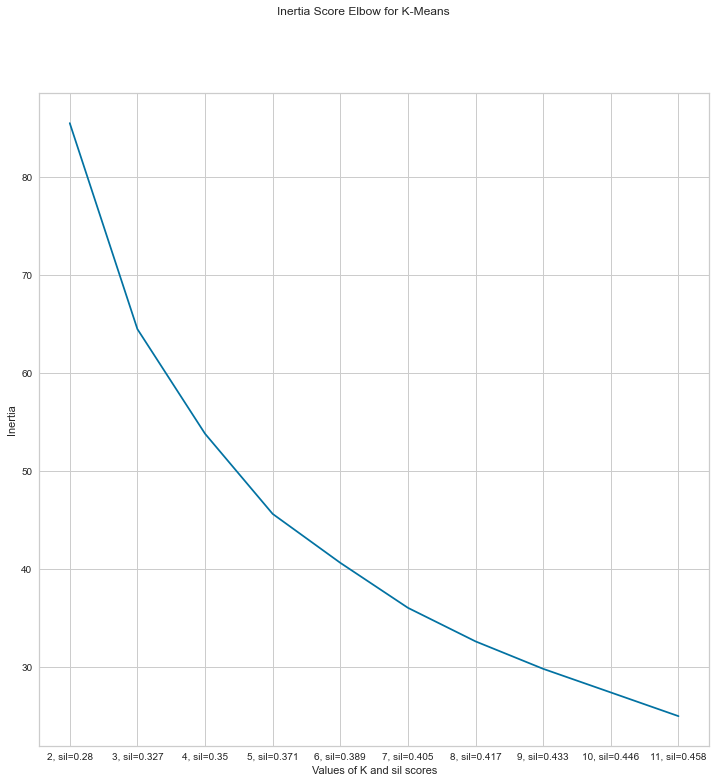

In [6]:
pca = PCA(n_components=9)
after_pca_trans_m_episodes = pca.fit_transform(transition_m_episodes)
_, _, final_labels = plotting_module.get_sil_scores_kmeans(after_pca_trans_m_episodes,
                                                           K=[2,3,4,5,6,7,8, 9, 10, 11],
                                                          savefig=True, name_saved_fig='K\inertia_after_pca.png')


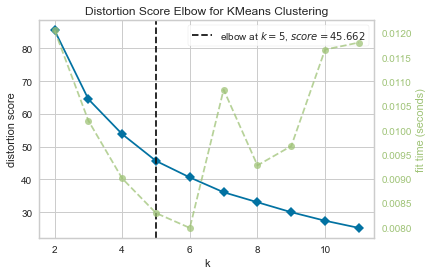

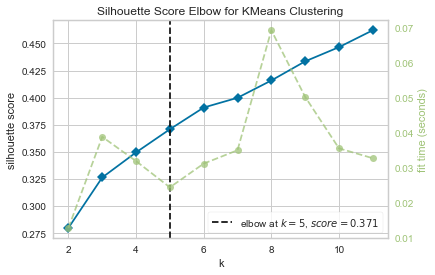

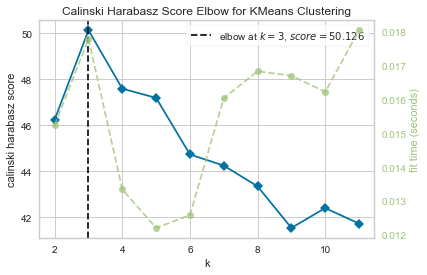

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [7]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(after_pca_trans_m_episodes)        
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')
visualizer.fit(after_pca_trans_m_episodes)        
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(after_pca_trans_m_episodes)        
visualizer.show() 

In all plots k=3 seems a reasonable candidate for an elbow. We restrict to the first 2 components of the pca

## Only with 2 components

Silhouette scores:  [0.496, 0.613, 0.563, 0.535, 0.545, 0.549, 0.544, 0.542, 0.549, 0.542]
Inertia:  [33.365, 12.492, 9.121, 6.149, 5.056, 4.164, 3.418, 2.936, 2.48, 2.177]


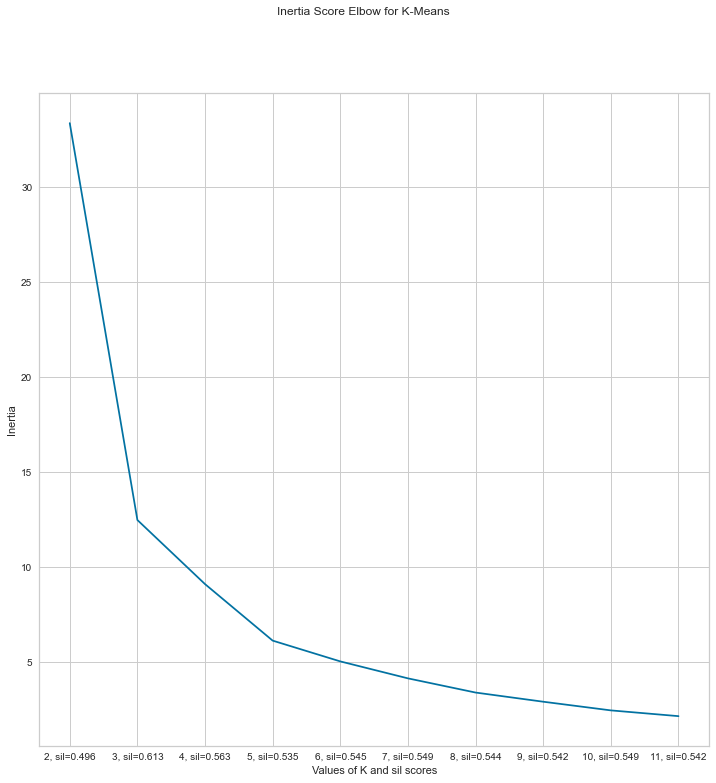

In [8]:
pca = PCA(n_components=2)
after_pca_trans_m_episodes_2cp = pca.fit_transform(transition_m_episodes)
_, _, final_labels_2cp = plotting_module.get_sil_scores_kmeans(after_pca_trans_m_episodes_2cp,
                                                               K=[2,3,4,5,6,7,8, 9, 10, 11],
                                                              savefig=True,
                                                               name_saved_fig='K\inertia_2components_pca.png')


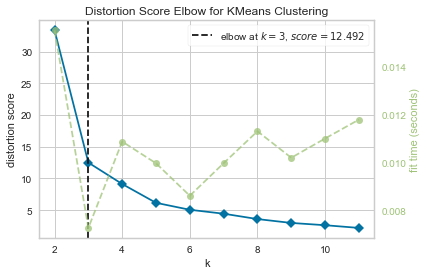

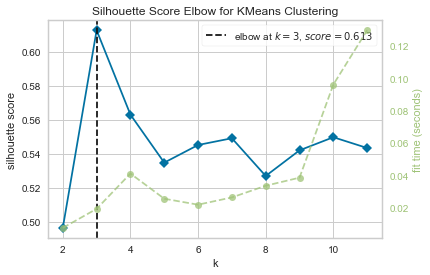

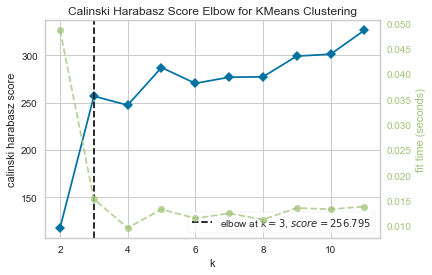

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(after_pca_trans_m_episodes_2cp)        
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')
visualizer.fit(after_pca_trans_m_episodes_2cp)        
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(after_pca_trans_m_episodes_2cp)
visualizer.show() 


We plot the clusters

## Plotting results

################
#### explained_variance_ratio_ with 2 components
[0.334, 0.221]
################


<Figure size 720x720 with 0 Axes>

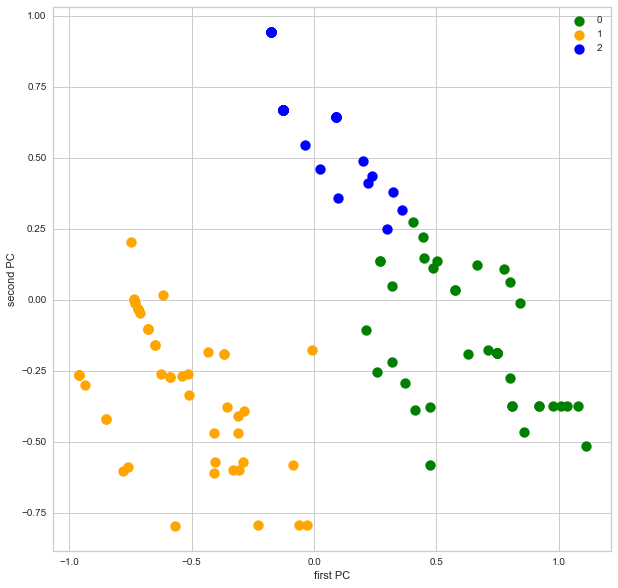

In [10]:
plotting_module.plot_components_pca(after_pca_trans_m_episodes,
                                    include_3d=False,
                                    labels=final_labels_2cp[1],
                                    savefig_2d=True,
                                    name_saved_fig_2d='Scatter_2cp_PCA_and_kmeans.png')

################
#### explained_variance_ratio_ with 2 components
[0.334, 0.221]
################


<Figure size 720x720 with 0 Axes>

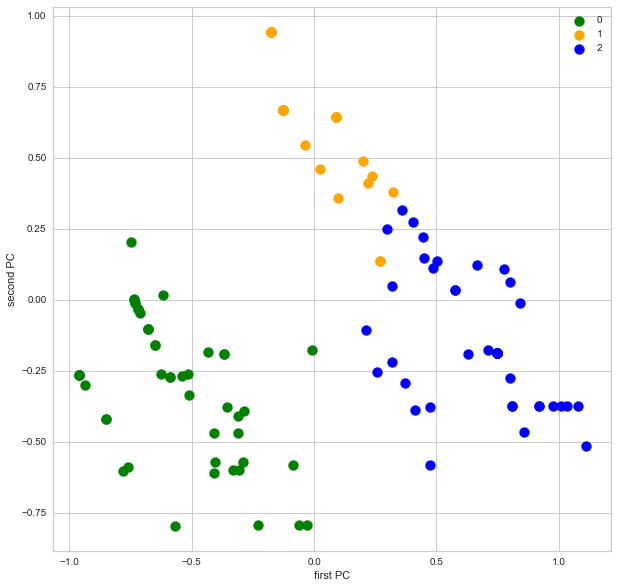

################
#### explained_variance_ratio_ with 3 components
[0.334, 0.221, 0.14]
################


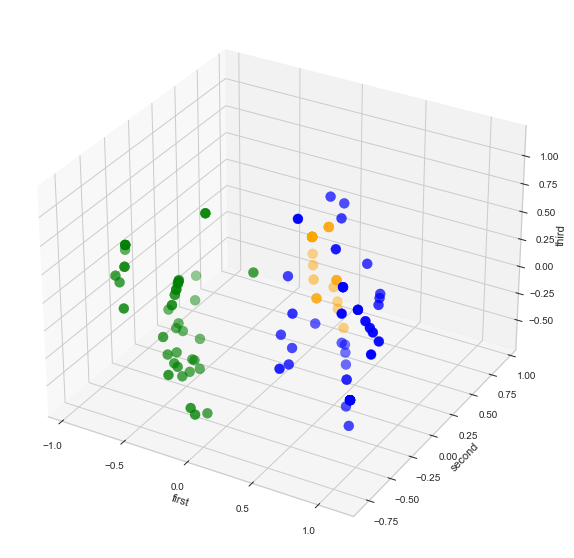

In [11]:
plotting_module.plot_components_pca(after_pca_trans_m_episodes, include_3d=True, labels=final_labels[1],
                                   savefig_2d=True, name_saved_fig_2d='Scatter_after_PCA_and_kmeans.png',
                                    savefig_3d=True,
                                   name_saved_fig_3d='3dcluster_after_PCA_and_kmeans.png')

## Plotting results with Gaussian Mixture 

################
#### explained_variance_ratio_ with 2 components
[0.334, 0.221]
################


<Figure size 720x720 with 0 Axes>

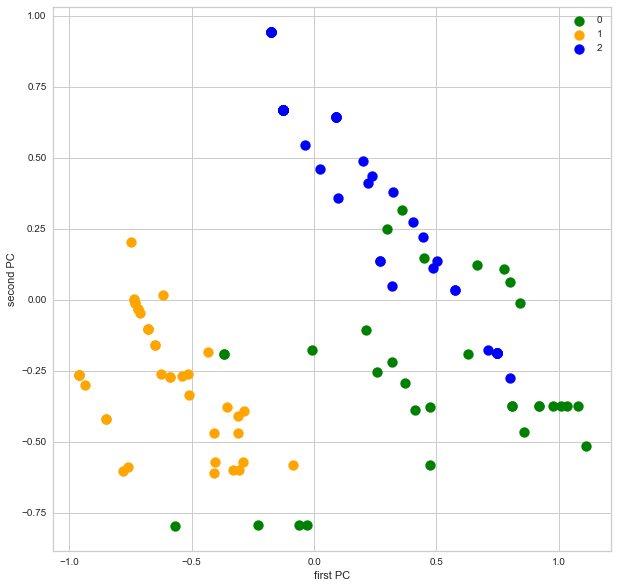

################
#### explained_variance_ratio_ with 3 components
[0.334, 0.221, 0.14]
################


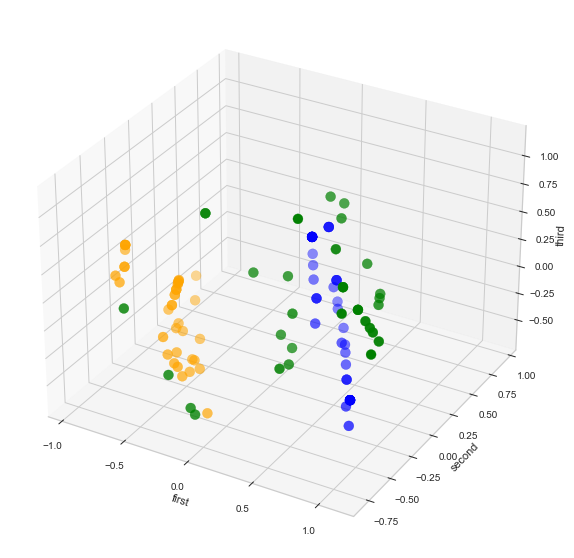

In [12]:
gm = GaussianMixture(n_components=3, random_state=0).fit_predict(after_pca_trans_m_episodes)
plotting_module.plot_components_pca(transition_m_episodes, labels=gm,
                                    savefig_2d=True, name_saved_fig_2d='Scatter_after_PCA_and_GM.png',
                                    savefig_3d=True,
                                    name_saved_fig_3d='3dcluster_after_PCA_and_GM.png')



## Average transitions within K-means clusters

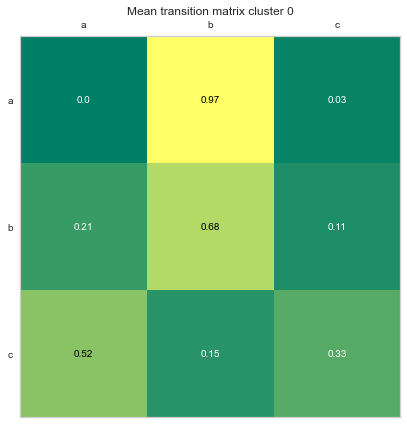

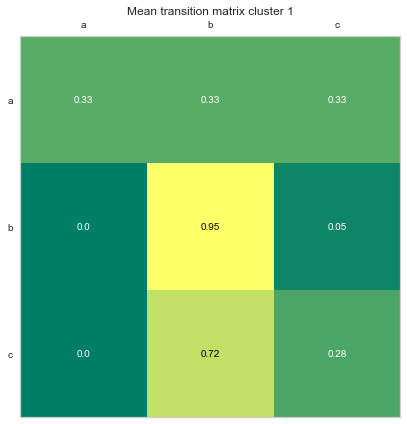

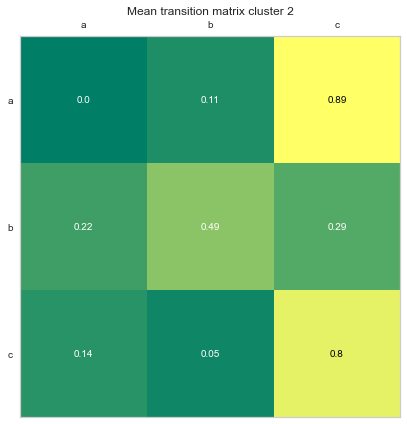

In [13]:
tr_matrices_0 = np.reshape(transition_m_episodes[final_labels[1]==0],((final_labels[1]==0).sum(), 3,3))
tr_matrices_1 = np.reshape(transition_m_episodes[final_labels[1]==1],((final_labels[1]==1).sum(), 3,3))
tr_matrices_2 = np.reshape(transition_m_episodes[final_labels[1]==2],((final_labels[1]==2).sum(), 3,3))


plotting_module.plot_cm(get_prob(np.mean(tr_matrices_0, axis=0)),
                        ['a','b','c'], 'Mean transition matrix cluster 0',
                        savefig=True, name_saved_fig='Mean_transition_matrix_cluster_0.png')
plotting_module.plot_cm(get_prob(np.mean(tr_matrices_1, axis=0)),
                        ['a','b','c'], 'Mean transition matrix cluster 1',
                        savefig=True, name_saved_fig='Mean_transition_matrix_cluster_1.png')
plotting_module.plot_cm(get_prob(np.mean(tr_matrices_2, axis=0)),
                        ['a','b','c'], 'Mean transition matrix cluster 2',
                        savefig=True, name_saved_fig='Mean_transition_matrix_cluster_2.png')



## Agglomerative Clustering and dendrogram

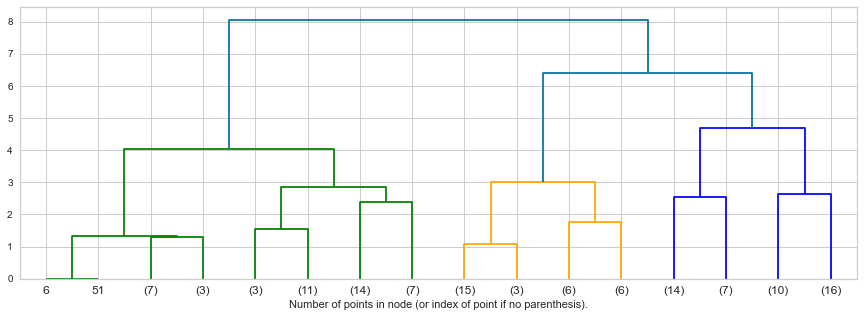

In [14]:

def plot_dendrogram(fitted_model):    
    # Create the counts of samples under each node
    counts = np.zeros(fitted_model.children_.shape[0])
    n_samples = len(fitted_model.labels_)
    for i, merge in enumerate(fitted_model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    # Create linkage matrix
    linkage_matrix = np.column_stack([fitted_model.children_, fitted_model.distances_, counts])
    # Plot the corresponding dendrogram
    plt.figure(figsize=(15,5))
    hierarchy.set_link_color_palette(['green', 'orange', 'blue'])
    dendrogram(linkage_matrix, truncate_mode="level", p=3, color_threshold=5.5) #at 5.5 we have 3 clusters
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.savefig('Dendogram_for_3_clusters', facecolor='white')
    plt.show()
    return linkage_matrix
    


X = transition_m_episodes
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
fitted_model = model.fit(X)

# plot the top three levels of the dendrogram
Z = plot_dendrogram(fitted_model)


################
#### explained_variance_ratio_ with 2 components
[0.334, 0.221]
################


<Figure size 720x720 with 0 Axes>

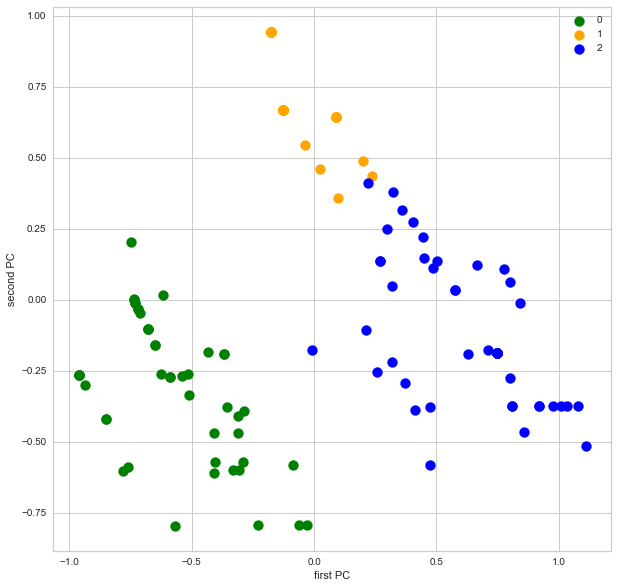

################
#### explained_variance_ratio_ with 3 components
[0.334, 0.221, 0.14]
################


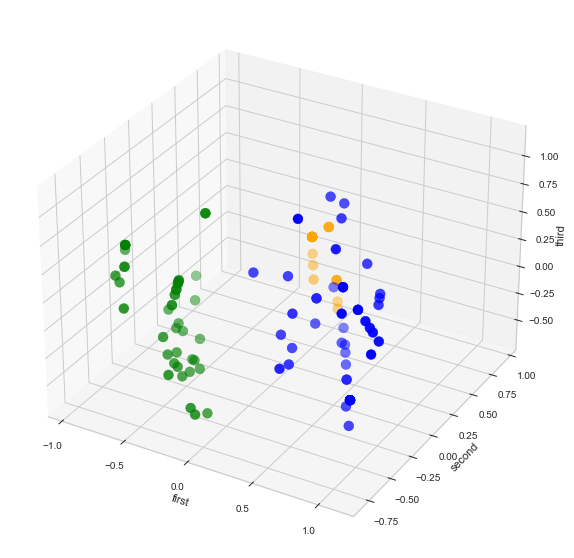

In [15]:
labels_ag = fcluster(Z, t=5.5, criterion='distance') #labels for Agglomerative Clustering
plotting_module.plot_components_pca(transition_m_episodes, labels=(labels_ag-1))

## Interactive 3d plot

################
#### explained_variance_ratio_ with 2 components
[0.334, 0.221]
################
################
#### explained_variance_ratio_ with 3 components
[0.334, 0.221, 0.14]
################


<IPython.core.display.Javascript object>


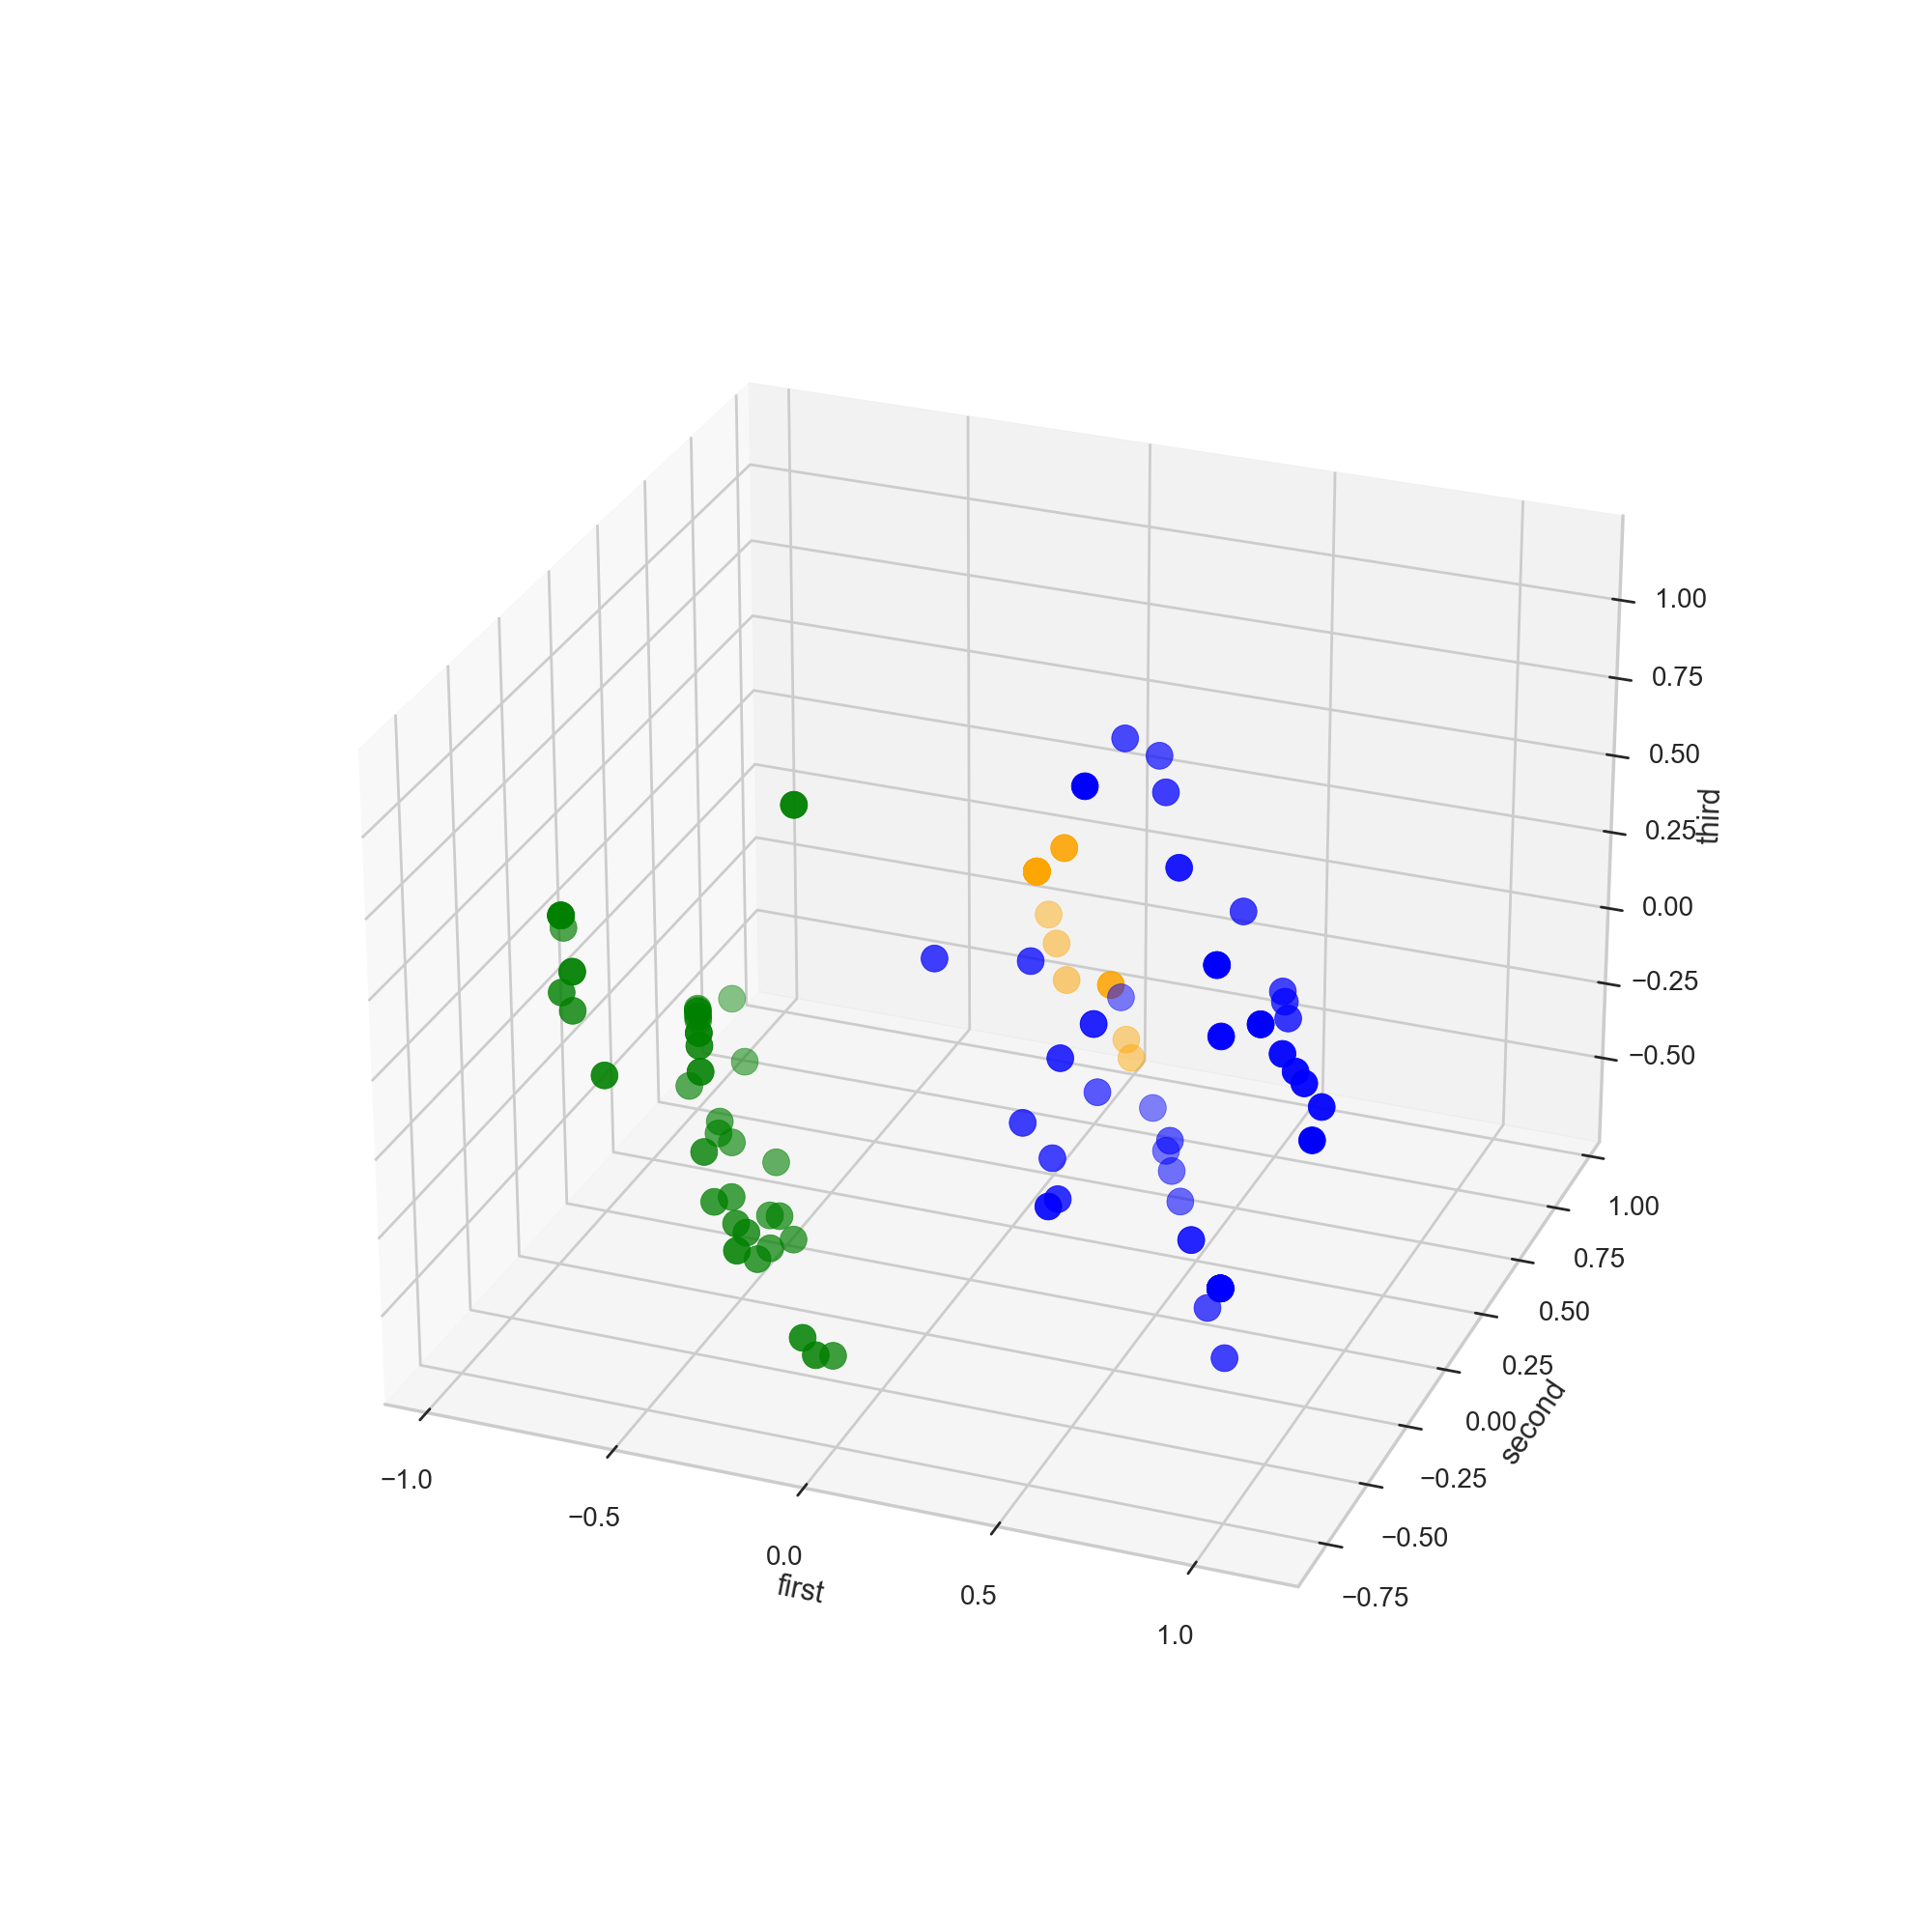

In [16]:
%matplotlib notebook

labels_ag = fcluster(Z, t=5.5, criterion='distance')
plotting_module.plot_components_pca(transition_m_episodes, include_2d=False, labels=(labels_ag-1))